## Demonstrating iteratively fitting resonator data 
#### 
#### We fit only to the magnitude of S21 since that is where the majority of our information about Q/Qc is. The phase data tells us about the phase asymmetry, which can either be reintroduced later or added artifically



### Fitting a Single Resonator Data Set

,Frequency,dBm,Phase,Ampl,Complex
0,5.859919e+09,-42.019908,-2.837548,0.007925,-0.007562-0.002373j
1,5.860003e+09,-41.775584,-2.984954,0.008151,-0.008051-0.001272j
2,5.860010e+09,-42.227502,-3.130633,0.007738,-0.007737-0.000085j
3,5.860012e+09,-43.658992,-3.243872,0.006562,-0.006528+0.000670j
4,5.860014e+09,-45.306898,-3.228894,0.005428,-0.005408+0.000473j
5,5.860016e+09,-46.910890,-3.025404,0.004513,-0.004482-0.000523j
6,5.860018e+09,-46.440037,-2.765484,0.004764,-0.004431-0.001750j
7,5.860020e+09,-44.696085,-2.665635,0.005824,-0.005176-0.002668j
8,5.860027e+09,-42.976229,-2.681671,0.007099,-0.006361-0.003151j
9,5.860111e+09,-41.896718,-2.795060,0.008038,-0.007560-0.002730j


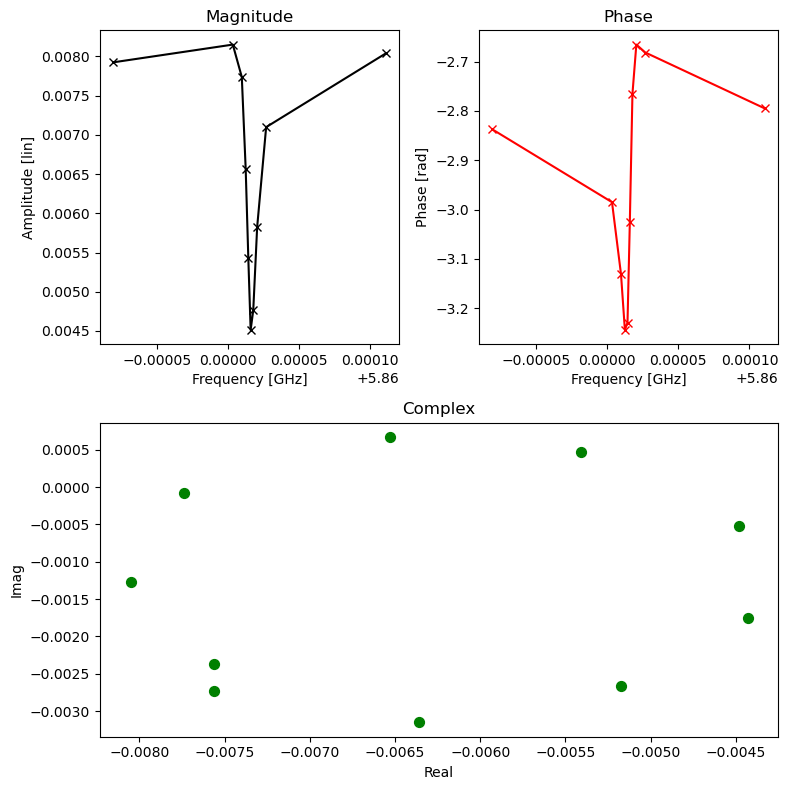

In [1]:
# load data from Andre
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import helper_functions as hf

data_dir = './samples/R0_Jorge/'
chosen_files = '*res0*'
data_files = glob.glob(data_dir+chosen_files)

df = pd.read_csv(data_files[0], sep=",", names=['Frequency','dBm','Phase'])

freq = df['Frequency']
df['Ampl'] = hf.s21_db_to_lin(df['dBm'])
df['Phase'] = np.unwrap(np.deg2rad(df['Phase']))
df['Complex'] = df['Ampl'] * np.exp(1j*df['Phase'] )

real = np.real(df['Complex'])
imag = np.imag(df['Complex'])
magn = df['Ampl']
phase = df['Phase']

display(df)

hf.display_resonator_data(freq, magn, phase)

pass


In [2]:
from lmfit import Model, Parameters
from fit_models import s21_hangarmode_abs

s21_lmfit_model = Model(s21_hangarmode_abs)

f0_guess_idx = magn.argmin()  # reasonable starting point
f0_guess = freq[f0_guess_idx]

result_magn = hf.quick_fit_to_magnitude(s21_lmfit_model, freq, magn, f0 = f0_guess)

# display(params)
print(result_magn.fit_report())


[[Model]]
    Model(s21_hangarmode_abs)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 819
    # data points      = 10
    # variables        = 4
    chi-square         = 7.6425e-07
    reduced chi-square = 1.2738e-07
    Akaike info crit   = -155.869497
    Bayesian info crit = -154.659157
    R-squared          = 0.95627190
[[Variables]]
    f0:  5.8600e+09 +/- 356.774702 (0.00%) (init = 5.860016e+09)
    Q:   624898.174 +/- 106106.517 (16.98%) (init = 10000)
    Qc:  405027.475 +/- 72793.0735 (17.97%) (init = 10000)
    A:   0.00810665 +/- 2.0853e-04 (2.57%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(Q, Qc)  = +0.9919
    C(Q, A)   = -0.6060
    C(Qc, A)  = -0.5439
    C(f0, Q)  = -0.1828
    C(f0, Qc) = -0.1654


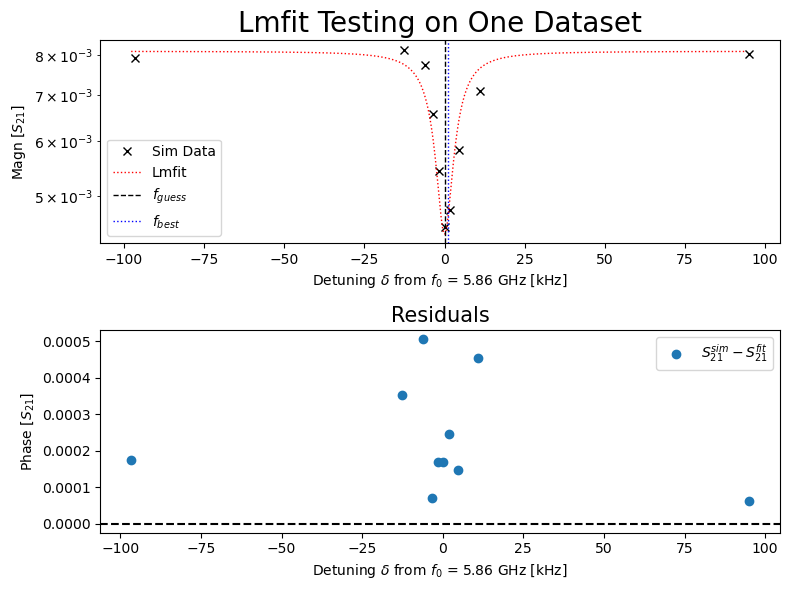

In [3]:
""" plot for simulation above """
f0_guess = result_magn.init_values['f0']
f0_final = result_magn.best_values['f0']

######### prepare fake data and start plot
fig1, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6))

ax1.plot((freq - f0_guess)/1e3, magn, 'kx', label='Sim Data')

freq_interp = np.linspace(freq.min(), freq.max(), len(freq)*100)
fit_interp = result_magn.eval(f=freq_interp)

ax1.plot((freq_interp - f0_final)/1e3, fit_interp, linestyle=':', color='r', linewidth=1, label='Lmfit')
# ax1.plot((freq - f0_final)/1e3, result_magn.best_fit, linestyle='--', color='red', label='Lmfit')

ax1.axvline((f0_guess - f0_guess)/1e3, linestyle='--', color='k', linewidth = 1, label='$f_{guess}$')
ax1.axvline((f0_final - f0_guess)/1e3, linestyle=':', color='b',  linewidth = 1, label='$f_{best}$')
ax1.legend()

#########
residuals = magn - result_magn.best_fit
ax2.scatter((freq - f0_guess)/1e3, np.abs(residuals), label='$S_{21}^{sim} - S_{21}^{fit}$', marker='o')
ax2.legend()

ax2.axhline(0, color='k', linestyle='--')

######### print some values before plot is shown
# print("Model Parameters:")
# display(params)
ax1.set_xlabel("Detuning $\\delta$ from $f_0$ = {:1.2f} GHz [kHz]".format(f0_guess/1e9))
ax1.set_ylabel("Magn [$S_{21}$]")
ax2.set_xlabel("Detuning $\\delta$ from $f_0$ = {:1.2f} GHz [kHz]".format(f0_guess/1e9))
ax2.set_ylabel("Phase [$S_{21}$]")

ax1.set_title("Lmfit Testing on One Dataset", fontsize=20)
ax2.set_title("Residuals", fontsize=15)

ax1.set_yscale('log')

# zoom_span = 0.1e6
# ax1.set_xlim(np.array([-zoom_span*5/1e3,   zoom_span*5/1e3]))
# ax2.set_xlim(np.array([-zoom_span/1e3, zoom_span/1e3]))

fig1.tight_layout()


### Load several sets of data

In [4]:
## now we do it iteratively
from lmfit import Model, Parameters

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob



data_dir = './samples/R0_Jorge/'
chosen_files = '*res0*'
data_files = glob.glob(data_dir+chosen_files)

data_sets = {}
for file_path in data_files:
    idx = file_path.lower().find('dbm')
    file_name = file_path[idx-3:-4]
    data_sets[file_name] = hf.load_and_prep_csv(file_path)


In [5]:
# perform fits iteratively
all_fit_results = {}
for file_name, dataframe in data_sets.items():
    # print(file_name)

    freq = dataframe[0]
    magn = dataframe[1]
    phase = dataframe[2]
    cmplx = dataframe[3]
    
    lmfit_model = Model(s21_hangarmode_abs)

    result_magn = hf.quick_fit_to_magnitude(lmfit_model, freq, magn)
    all_fit_results[file_name] = result_magn

# sort the dictionary by decreasing power using this hack
all_fit_results = dict(sorted(all_fit_results.items(), key=lambda item: item[0]))


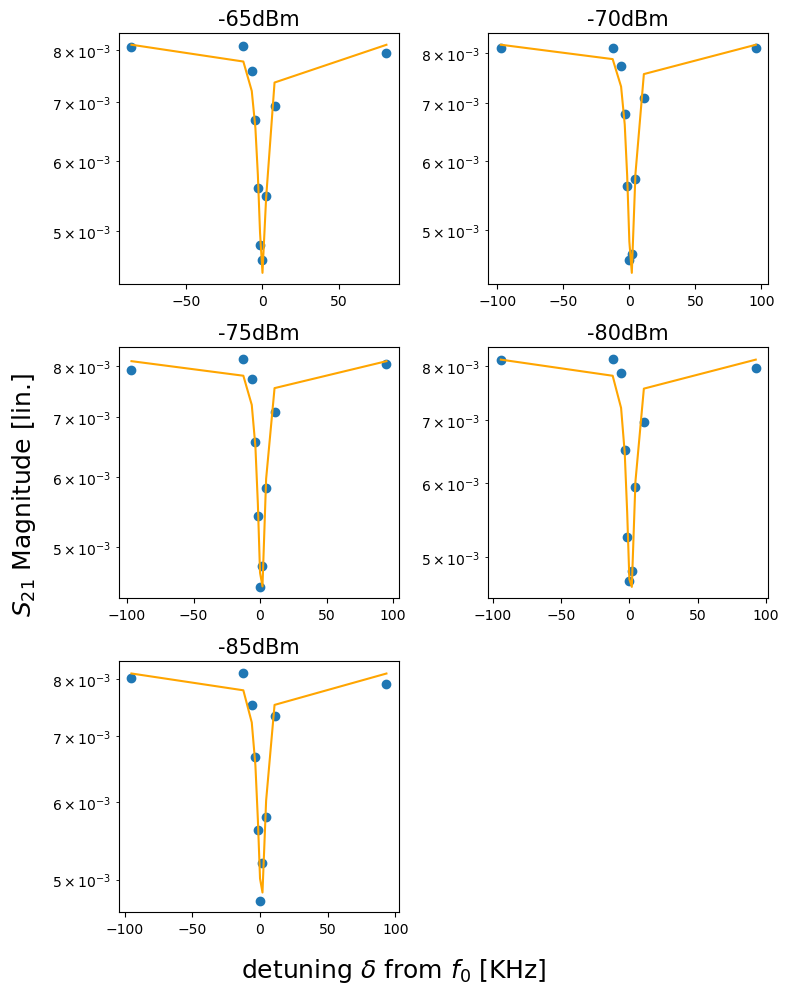

In [15]:
# plot fits, copy pasted code from stackexchange

N = len(all_fit_results)  
cols = 2

fig, axes = hf.col_by_n_plots(N, cols)
for i, (data_set, fit_result) in enumerate(all_fit_results.items()):
    ax = axes[i]

    freq = data_sets[data_set][0]
    f0 = fit_result.init_values['f0']

    ax.plot((freq - f0)/1e3, fit_result.best_fit, color='orange')
    ax.scatter((freq - f0)/1e3, fit_result.data)

    ax.set_title(data_set[0:6], fontsize=15)
    ax.set_yscale("log")

    # print(fit_result.fit_report())

fig.supylabel("$S_{21}$ Magnitude [lin.]", fontsize=18)
fig.supxlabel("detuning $\\delta$ from $f_0$ [KHz]", fontsize=18)
fig.set_size_inches(8,10,forward=True)
fig.tight_layout()


